In [1]:
import numpy as np
import weathering_calibration
import scipy.io as sp
import xarray as xr
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import optimize


In [2]:
#load our data
#forcings
file_to_open_INTERPSTACK = '../SCION_model/forcings/INTERPSTACK_sep2021_v5.mat'
mat_contents = sp.loadmat( file_to_open_INTERPSTACK)
file_to_open_ROOTS = '../SCION_model/forcings/root_presence.mat'
root_maps = sp.loadmat(file_to_open_ROOTS)

#river data SCION
river_poly_file_FOAM = './Maffre_equations/all_basin_FOAM-48x40.nc'
river_poly_FOAM = xr.open_dataset(river_poly_file_FOAM)
polygon_area_FOAM = river_poly_FOAM['polygon_area']

#river data PD
river_poly_file_PD = './Maffre_equations/all_basin_0.5deg.nc'
river_poly_PD = xr.open_dataset(river_poly_file_PD)
polygon_area_PD = river_poly_PD['polygon_area']

#for evaluation
WorldRivers_file = './Maffre_equations/WorldRivers.mat'
WorldRivers = sp.loadmat(WorldRivers_file)
WorldRivers_array = (WorldRivers['WorldRivers'] * 1e6).reshape(len(WorldRivers['WorldRivers']),)

In [3]:
#SCION data
lat_FOAM = mat_contents['INTERPSTACK'][0][0][5][0]
lon_FOAM = mat_contents['INTERPSTACK'][0][0][6][0]
land_FOAM = mat_contents['INTERPSTACK'][0][0][4][:,:,21] #present day land
sutures_FOAM = mat_contents['INTERPSTACK'][0][0][10][:,:,21] #present day sutures
arcs_FOAM = mat_contents['INTERPSTACK'][0][0][14][:,:,21]*2 #present day arcs
relict_arcs_FOAM = mat_contents['INTERPSTACK'][0][0][13][:,:,21]
slope_FOAM = mat_contents['INTERPSTACK'][0][0][16][:,:,21]

#make sure relict arcs aren't overlapping with active arcs
relict_arcs_FOAM = relict_arcs_FOAM*(arcs_FOAM == 0).astype(int)
relict_arcs_FOAM = np.minimum(1, (relict_arcs_FOAM * 2))
root_presence = root_maps['root_presence'][:,:,21]

#### weathering calculation fields, temperature and runoff at preindustrial CO2 with 
T_FOAM = mat_contents['INTERPSTACK'][0][0][2][:,:,7,21] + 273 ### K
Q_FOAM = mat_contents['INTERPSTACK'][0][0][3][:,:,7,21] ### mm/yr

#### only have land
T_FOAM = T_FOAM * land_FOAM
Q_FOAM = Q_FOAM * land_FOAM

In [4]:
#Compute our 'real world' present day values

file_to_open_CRU_dataset ='./Maffre_equations/CRU_dataset.mat'
CRU_dataset = sp.loadmat(file_to_open_CRU_dataset)

lat = np.copy(CRU_dataset['lat'])
lon = np.copy(CRU_dataset['lon'])
pre_avg = np.copy(CRU_dataset['pre_avg'])
tmp_avg = np.copy(CRU_dataset['tmp_avg'])

file_to_open_NASA_data ='./Maffre_equations/NASA_topo.mat'
NASA_data = sp.loadmat(file_to_open_NASA_data)

NASA_lat = np.copy(NASA_data['NASA_lat'])
NASA_lon = np.copy(NASA_data['NASA_lon'])
NASA_topo = np.copy(NASA_data['NASA_topo'])

#### read regridded runoff from fekek eet al., 2002
file_to_open_fekeke_run_regrid ='./Maffre_equations/fekeke_run_regrid.mat'
fekeke_run_regrid = sp.loadmat(file_to_open_fekeke_run_regrid)

run_lat = np.copy(fekeke_run_regrid['run_lat'])
run_lon = np.copy(fekeke_run_regrid['run_lon'])
run_data = np.copy(fekeke_run_regrid['run_data'])

run_data[run_data < 0] = 0
run_data[np.isnan(run_data) == 1] = 0

#### find land
land = tmp_avg > -999
### remove water temps at -999
tmp_avg[tmp_avg < -100] = 15

### remove water
tmp_avg = tmp_avg*land 
tmp_avg[tmp_avg == 0] = np.nan
pre_avg[pre_avg < 0] = 0
##get oceans

#transpose and flip
tmp_avg = np.flipud(tmp_avg.T)
run_data = np.flipud(run_data)
#topo = np.copy(np.flipud(NASA_topo))
topo = NASA_topo
topo[topo==99999] = 0

bulkbasinweathering_PD = weathering_calibration.get_HADCM3_weathering_PD(tmp_avg, topo, lat, lon, run_data, polygon_area_PD)

/Users/andrew/Documents/GitHub/pySCION_roots/src/python/weathering_calibration.py:160: RuntimeWarning: divide by zero encountered in true_divide
  R_reg = ( (z/epsilon)**sigplus1 ) / sigplus1
/Users/andrew/Documents/GitHub/pySCION_roots/src/python/weathering_calibration.py:163: RuntimeWarning: invalid value encountered in multiply
  CW = epsilon * Xm * ( 1 - np.exp( -1 * K * R_Q * R_T * R_reg ) ) * 1e6


In [6]:
#default SCION run, variables for basic weathering equations already established for main pySCION paper
#not rerun here, but could be
#default_variables = [6e-5, 1e-3, 0.9, 1/1000000, 1/1000000, 1/1000000] #geology and roots

default_variables = [1/1000000] #just roots
constants_data_FOAM = [slope_FOAM, T_FOAM, Q_FOAM, polygon_area_FOAM,
                       sutures_FOAM,  arcs_FOAM, relict_arcs_FOAM, root_presence]

bulkbasinweathering_FOAM = weathering_calibration.get_basin_weathering(default_variables, constants_data_FOAM)
#get weathering data
#initial_variables = [6e-5, 1e-5, 0.9/1000, 1/1000000, 1/1000000, 1/1000000]
#weathering = weathering_calibration.get_basin_weathering(initial_variables, constants_data_FOAM)

6.2e-05 0.814 0.636 12 70 1.0


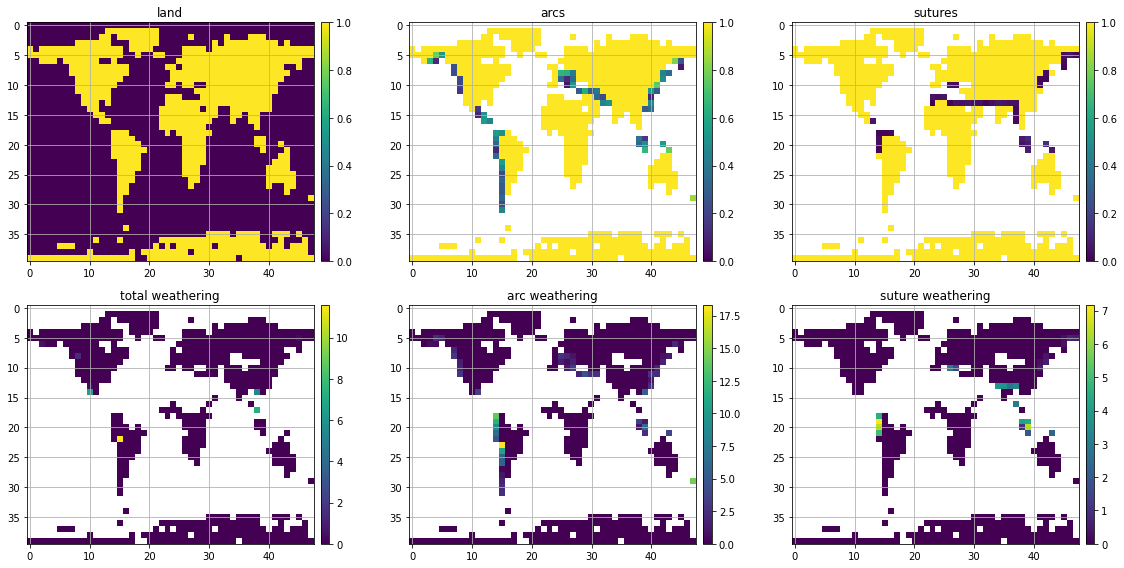

In [7]:
fig, ((ax1, ax2, ax3),
      (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(16,8))

tmp_sutures = np.where(sutures_FOAM!=0, sutures_FOAM, land_FOAM)
tmp_arcs = np.where(arcs_FOAM!=0, arcs_FOAM, land_FOAM)

tmp_sutures[tmp_sutures==0] = np.nan
tmp_arcs[tmp_arcs==0] = np.nan
    
im1 = ax1.imshow(land_FOAM)
ax1.set_title('land')
ax1.grid()
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes('right', size='3%', pad=0.1)
fig.colorbar(im1, cax=cax1)#, fraction=0.038, pad=0.04)

im2 = ax2.imshow(tmp_arcs, vmin=0, vmax=1)
ax2.set_title('arcs')
ax2.grid()
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes('right', size='3%', pad=0.1)
fig.colorbar(im2, cax=cax2)#, fraction=0.038, pad=0.04)


im3 = ax3.imshow(tmp_sutures, vmin=0, vmax=1)
ax3.set_title('sutures')
ax3.grid()
divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes('right', size='3%', pad=0.1)
fig.colorbar(im3, cax=cax3)#, fraction=0.038, pad=0.04)
#fig.suptitle('%s, %s Ma' % (ind, time), x=0.5, y=.62, fontsize=20)

#____

im4 = ax4.imshow(bulkbasinweathering_FOAM[3])#, vmin=0, vmax=1)
ax4.set_title('total weathering')
ax4.grid()
divider4 = make_axes_locatable(ax4)
cax4 = divider4.append_axes('right', size='3%', pad=0.1)
fig.colorbar(im4, cax=cax4)#, fraction=0.038, pad=0.04)

im5 = ax5.imshow(bulkbasinweathering_FOAM[1])
ax5.set_title('arc weathering')
ax5.grid()
divider5 = make_axes_locatable(ax5)
cax5 = divider5.append_axes('right', size='3%', pad=0.1)
fig.colorbar(im5, cax=cax5)#, fraction=0.038, pad=0.04)


im6 = ax6.imshow(bulkbasinweathering_FOAM[2])
ax6.set_title('suture weathering')
ax6.grid()
divider6 = make_axes_locatable(ax6)
cax6 = divider6.append_axes('right', size='3%', pad=0.1)
fig.colorbar(im6, cax=cax6)#, fraction=0.038, pad=0.04)
#fig.suptitle('%s, %s Ma' % (ind, time), x=0.5, y=.62, fontsize=20)
fig.tight_layout()



In [10]:
#optimisation
ys = WorldRivers_array

#define our function that we pass to our least squares optimisation, we just want to minimise against present-day
def fun(variables):
    return weathering_calibration.get_basin_weathering(variables, constants_data_FOAM)[0]-ys

In [11]:

#initial_variables = [6e-5, 1e-5, 0.6/1000, 200/1000000, 700/1000000, 10/1000000]
initial_variables = [10/1000000] #just root factor, assuming others were previously defined

#best fit
#bounds = ([7.6e-6, 1.5e-6, 0.6/1000, 1/1000000, 1/1000000],
#          [1.2e-3, 3.0e-4, 1.13/1000, 1000/1000000, 1000/1000000])
#no bounds
#bounds = ([-np.inf, -np.inf, -np.inf, -np.inf, -np.inf],
#           [np.inf, np.inf, np.inf, np.inf, np.inf])
#expected bounds
#bounds = ([-np.inf, -np.inf, 0.553/1000, 1/1000000, 10/1000000, 0.9/1000000],
#          [np.inf, np.inf, 0.646/1000, 1000/1000000, 1000/1000000,1.1/1000000])
res = optimize.least_squares(fun, initial_variables)#, bounds=bounds)

bulkbasinweathering_OPTIMISED = weathering_calibration.get_basin_weathering(res.x, constants_data_FOAM)

#r2
RSS = sum(res.fun**2)
TSS = sum(( WorldRivers_array - np.mean(WorldRivers_array) ) **2)
r2 = 1 - RSS/TSS
print(r2, res.x)

6.2e-05 0.814 0.636 12 70 10.0
6.2e-05 0.814 0.636 12 70 10.014901161193848
6.2e-05 0.814 0.636 12 70 1.028596480851229
6.2e-05 0.814 0.636 12 70 1.0434976420450766
6.2e-05 0.814 0.636 12 70 1.0285964808513526
6.2e-05 0.814 0.636 12 70 1.0434976420452002
6.2e-05 0.814 0.636 12 70 1.0285964808513526
0.09741878418863392 [1.02859648e-06]


/Users/andrew/Documents/GitHub/pySCION_roots/src/python/weathering_calibration.py:56: RuntimeWarning: divide by zero encountered in true_divide
  R_T = np.exp( ( Ea / (R*T0) ) - ( Ea / (R*T) ) )
/Users/andrew/Documents/GitHub/pySCION_roots/src/python/weathering_calibration.py:58: RuntimeWarning: divide by zero encountered in true_divide
  R_reg = ( (z/epsilon)**sigplus1) / sigplus1
/Users/andrew/Documents/GitHub/pySCION_roots/src/python/weathering_calibration.py:68: RuntimeWarning: invalid value encountered in multiply
  CW_raw = epsilon * Xm * ( 1 - np.exp( -1* K * R_Q * R_T * R_reg ) ) * 1e6


In [12]:
print(initial_variables)
res.x

[1e-05]


array([1.02859648e-06])

In [13]:
#get linear correlation
x_value = bulkbasinweathering_OPTIMISED[0][np.nonzero(bulkbasinweathering_OPTIMISED[0])]
y_value = WorldRivers_array[np.nonzero(bulkbasinweathering_OPTIMISED[0])]
correlation_matrix = np.corrcoef(x_value, y_value)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
print(correlation_xy, r_squared)

0.3893198550986411 0.1515699495740269


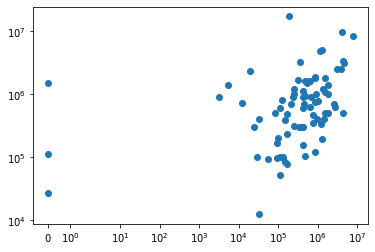

In [14]:
plt.scatter(bulkbasinweathering_OPTIMISED[0], WorldRivers_array)
plt.yscale('symlog')
plt.xscale('symlog')

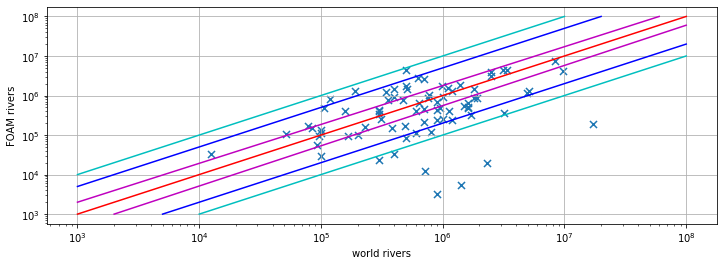

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,4))

ax.scatter(WorldRivers_array, bulkbasinweathering_OPTIMISED[0], marker='x', s=50)
#ax.plot(WorldRivers_array, y, c='orange')
ax.set_yscale('log')
ax.set_xscale('log')
#ax3.set_xlim(1e3,1e8)
#ax3.set_ylim(1e3,1e8)
#ax.set_title('opt. || SF: %s | K: %s | kw: %s | sig: %s' % (np.round(res.x[3]*1000000,3),
##                                                                f'{res.x[0]:.1e}',
 #                                                               np.round(res.x[1],3),
 #                                                               np.round(res.x[2]*1000,2)))
ax.set_xlabel('world rivers')
ax.set_ylabel('FOAM rivers')
ax.grid()

# plot equivalence line
ax.plot([1e3, 1e8],[1e3, 1e8],'r')
## plot 10 fold difference
ax.plot([1e4, 1e8],[1e3, 1e7], 'c')
ax.plot([1e3, 1e7],[1e4, 1e8], 'c')
### plot 5 fold difference
ax.plot([5e3, 1e8],[1e3, 2e7],'b')
ax.plot([1e3, 2e7],[5e3, 1e8],'b')
### plot 2 fold difference
ax.plot([2e3, 1e8],[1e3, 6e7],'m')
ax.plot([1e3, 6e7],[2e3, 1e8],'m')


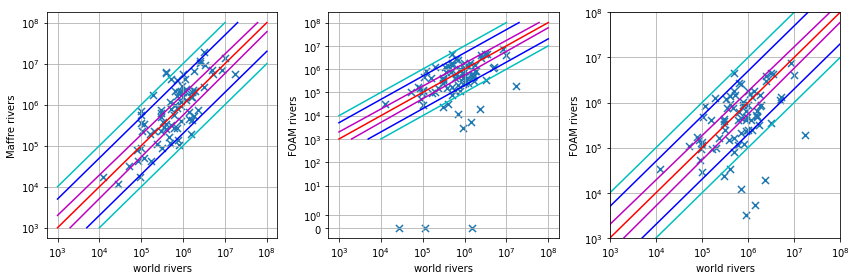

In [18]:
#world river comparisons
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

#world river comparisons
WorldRivers_file = './Maffre_equations/WorldRivers.mat'
WorldRivers = sp.loadmat(WorldRivers_file)
ax1.scatter(WorldRivers_array, bulkbasinweathering_PD, marker='x', s=50)
ax1.set_yscale('symlog')
ax1.set_xscale('symlog')
#ax1.set_xlim(1e3,1e8)
#ax1.set_ylim(1e3,1e8)
#ax1.set_title('PD || K: %s | kw: %s | sig: %s' % (K, kw, sigplus1))
ax1.set_xlabel('world rivers')
ax1.set_ylabel('Maffre rivers')
ax1.grid()

# plot equivalence line
ax1.plot([1e3, 1e8],[1e3, 1e8],'r')
# plot 10 fold difference
ax1.plot([1e4, 1e8],[1e3, 1e7], 'c')
ax1.plot([1e3, 1e7],[1e4, 1e8], 'c')
## plot 5 fold difference
ax1.plot([5e3, 1e8],[1e3, 2e7],'b')
ax1.plot([1e3, 2e7],[5e3, 1e8],'b')
## plot 2 fold difference
ax1.plot([2e3, 1e8],[1e3, 6e7],'m')
ax1.plot([1e3, 6e7],[2e3, 1e8],'m')

ax2.scatter(WorldRivers_array, bulkbasinweathering_FOAM[0], marker='x', s=50)
ax2.set_yscale('symlog')
ax2.set_xscale('symlog')
#ax2.set_xlim(1e3,1e8)
#ax2.set_ylim(1e3,1e8)
#ax2.set_title('norm || SF: %s | K: %s | kw: %s | sig: %s' % (default_variables[3],
##                                                             default_variables[0],
 #                                                            default_variables[1],
 #                                                            default_variables[2]))
ax2.set_xlabel('world rivers')
ax2.set_ylabel('FOAM rivers')
ax2.grid()

# plot equivalence line
ax2.plot([1e3, 1e8],[1e3, 1e8],'r')
# plot 10 fold difference
ax2.plot([1e4, 1e8],[1e3, 1e7], 'c')
ax2.plot([1e3, 1e7],[1e4, 1e8], 'c')
## plot 5 fold difference
ax2.plot([5e3, 1e8],[1e3, 2e7],'b')
ax2.plot([1e3, 2e7],[5e3, 1e8],'b')
## plot 2 fold difference
ax2.plot([2e3, 1e8],[1e3, 6e7],'m')
ax2.plot([1e3, 6e7],[2e3, 1e8],'m')

ax3.scatter(WorldRivers['WorldRivers'] * 1e6, bulkbasinweathering_OPTIMISED[0], marker='x', s=50)
ax3.set_yscale('symlog')
ax3.set_xscale('symlog')
ax3.set_xlim(1e3,1e8)
ax3.set_ylim(1e3,1e8)
#ax3.set_title('opt. || AF: %s | K: %s | kw: %s | sig: %s' % (np.round(res.x[3]*1000000,3),
#                                                                f'{res.x[0]:.1e}',
#                                                                np.round(res.x[1],3),
#                                                                np.round(res.x[2]*1000,2)))

#In [31]: num = 0.09112346
#In [32]: f'{num:.5E}'
#Out[32]: '9.11235E-02'
    
    
ax3.set_xlabel('world rivers')
ax3.set_ylabel('FOAM rivers')
ax3.grid()

# plot equivalence line
ax3.plot([1e3, 1e8],[1e3, 1e8],'r')
# plot 10 fold difference
ax3.plot([1e4, 1e8],[1e3, 1e7], 'c')
ax3.plot([1e3, 1e7],[1e4, 1e8], 'c')
## plot 5 fold difference
ax3.plot([5e3, 1e8],[1e3, 2e7],'b')
ax3.plot([1e3, 2e7],[5e3, 1e8],'b')
## plot 2 fold difference
ax3.plot([2e3, 1e8],[1e3, 6e7],'m')
ax3.plot([1e3, 6e7],[2e3, 1e8],'m')

fig.tight_layout()

